In [ ]:
# CSCI6380 Data Mining: Assignment #3
## Adnan Kivanc Corut

________________

In [ ]:
### Importing Libraries

In [2]:
from pathlib import Path
import glob
import os
import string
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm,t, binom
from scipy import stats

## Problem 1 - Calculate Classification Metrics

### Input Data Manipulation

In [3]:
dataA  = pd.read_csv("/Users/kivanc/DataMining-ML/Data/ModelEval/Data-A.csv", header=0)

dataA = dataA[["Actual","M2"]]
#dataA.head()

conditions = [(dataA['M2'] >= 0.5) , (dataA['M2'] < 0.5)]
values = [1.0, 0.0]

dataA['Predicted'] = np.select(conditions, values)
dataA.head()

,Actual,M2,Predicted
0,1.0,0.888361,1.0
1,1.0,0.842602,1.0
2,1.0,0.584694,1.0
3,1.0,0.973291,1.0
4,1.0,0.274050,0.0


### Define the Functions

In [10]:
def confusionMatrix (df):
    """
    Function to produce confusion matrix.
    Takes a dataframe as parameter. This 
    dataframe has actual scores in one column 
    and predicted scores in the second column.
    """
    conf_matrix = pd.DataFrame(np.zeros((2,2)), columns = ['Positive', 'Negative'],  
                   index = ['Positive', 'Negative']) 
    
    for row in df.itertuples(index=True, name='Pandas'):
        if (row.Actual == 1.0 and row.Predicted == 1.0):
            conf_matrix.at['Positive', 'Positive'] += 1
        if (row.Actual == 0.0 and row.Predicted == 0.0):
            conf_matrix.at['Negative', 'Negative'] += 1
        if (row.Actual == 0.0 and row.Predicted == 1.0):
            conf_matrix.at['Negative', 'Positive'] += 1
        if (row.Actual == 1.0 and row.Predicted == 0.0):
            conf_matrix.at['Positive', 'Negative'] += 1

    return conf_matrix

In [13]:
def calcMetrics (conf_matrix):
    """
    Function to calculate classification
    metrics from a confusion matrix.
    """
    TP = conf_matrix.iat[0,0]
    FN = conf_matrix.iat[0,1]
    FP = conf_matrix.iat[1,0]
    TN = conf_matrix.iat[1,1]
    TP_Rate = TP/(TP+FN)
    FP_Rate = FP/(TN+FP)
    TN_Rate = TN/(TN+FP)
    FN_Rate = FN/(FN+TP)
    print("True Positive Rate:\t",TP_Rate)
    print("False Positive Rate:\t",FP_Rate)
    print("True Negative Rate:\t",TN_Rate)
    print("False Negative Rate:\t",FN_Rate)
    print('_'*30)

    # Calculate success rate
    Succ_Rate = (TP+TN)/(TP+TN+FP+FN)
    #metrics_df['Success(Accuracy)'] = Succ_Rate
    
    # Calculate precision
    Precision = TP/(TP+FP)
    # Calculate recall
    Recall = TP_Rate
    # Calculate F1-Score
    F1_Score = 2*(Precision * Recall)/(Precision+Recall)
   
    # Calculate the Matthews correlation coefficient
    MCC = ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    
    # Calculate Kappa score
    Accuracy = Succ_Rate
    ## Source: https://en.wikipedia.org/wiki/Cohen's_kappa
    Exp_Accuracy = ((TP + FN) * (TP + FP) + (FP + TN) * (FN + TN)) / ((TP + TN + FP + FN)**2)
    Kappa_Score = (Accuracy - Exp_Accuracy)/(1 - Exp_Accuracy)
    
    metrics_data= [[Succ_Rate, Precision, Recall, FP_Rate, F1_Score, MCC, Kappa_Score]]
    metrics_df = pd.DataFrame(metrics_data, index=['Model Scores'], columns = ['Success(Accuracy)', 'Precision', 'Recall(TP-Rate)', 'FP-Rate', 'F1-Score', 'MCC', 'Kappa']) 
    
    return metrics_df
    


### Compute the Confusion Matrix

In [14]:
## Compute the confusion matrix
cmA = confusionMatrix(dataA)
print('', 'Confusion Matrix',sep="\t")
print('_'*30)
print(cmA)
print('_'*30)



	Confusion Matrix
______________________________
          Positive  Negative
Positive     221.0      29.0
Negative      71.0     179.0
______________________________


### Compute the Classification Metrics

In [15]:
## Calculate classification metrics
calcMetrics(cmA)

True Positive Rate:	 0.884
False Positive Rate:	 0.284
True Negative Rate:	 0.716
False Negative Rate:	 0.116
______________________________


,Success(Accuracy),Precision,Recall(TP-Rate),FP-Rate,F1-Score,MCC,Kappa
Model Scores,0.8,0.756849,0.884,0.284,0.815498,0.608651,0.6


______________________

## Problem 2 - Generating an ROC curve

### Define the Functions

In [18]:
def make_ROC(data_actual, data_predict):
    """
    Function to compute ROC. Takes two
    parameters: first is actual scores,
    and second is predicted scores.
    """
    N=len(data_actual)

    TPF=[]
    FPF=[]
    threshold=0
    j=0
    increment=1/N

    while(threshold<=1.1):
        #threshold=i
        TP, FP, TN, FN = 0, 0, 0, 0
        # Accumulate the true/false negative/positives
        for j in range(N):
            if data_actual[j]==1:
                if data_predict[j]>=threshold:
                    TP+=1
                else:
                    FN+=1
            if data_actual[j]==0:
                if data_predict[j]>=threshold:
                    FP+=1
                else:
                    TN+=1

        # Calcualate true positive rate for current threshold.           
        TP_Rate=TP/(TP + FN)

        # Calcualate false positive rate for current threshold. 
        FP_Rate=FP/(FP + TN)

        TPF.append(TP_Rate)
        FPF.append(FP_Rate)

        threshold+=increment

    return TPF, FPF

def plot_ROC(data_actual, data_predict):
    """
    Function to make ROC curve plot. Takes false
    positive rate and true positive rates list as
    parameters.
    """
    # Get True Positive Rate and False Positive Rate lists
    TPF, FPF = make_ROC(data_actual, data_predict)
    # Plot the ROC curve
    fig = plt.figure(figsize=(8,6))
    plt.title('ROC Curve')
    plt.plot(FPF, TPF, label='ROC Curve')
    plt.plot([0, 1], ls="--", label='Random Classifier')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.show()

### Compute and Plot the ROC

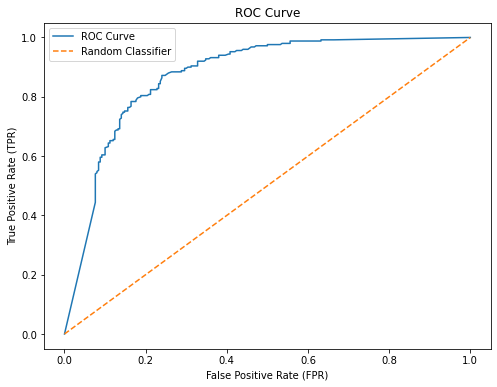

In [19]:
## Input data manipulation
dataA_actual = np.asarray(dataA['Actual'])
dataA_M2 = np.asarray(dataA['M2'])

## Plot the ROC curve
plot_ROC(dataA_actual, dataA_M2)

_____________________

## Problem 3 - Performing t-test

### Define the Functions

In [22]:
def std_dev(data):
    """
    Function to calculate standard devaiation
    from a given data.
    """
    n = len(data)
    mean_data = sum(data)/n
    sum_of_square = 0
    for i in data:
        sum_of_square += (i-mean_data)**2
    sigsq = sum_of_square/(n-1)
    stdv = math.sqrt(sigsq)
    return stdv

def paired_ttest(data1, data2):
    """
    Function to perform independent two-sample
    t-test on two datasets. This function also
    calculates the p-value for hypothesis testing.
    """

    # Get means of eacg dataset
    mean_data1 = sum(data1)/len(data1)
    mean_data2 = sum(data2)/len(data2)

    # Get standard deviations of each dataset
    sd_data1 = std_dev(data1)
    sd_data2 = std_dev(data2) 

    # standard error of the difference between two means
    ## Source: https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test
    SE_mean_d1_d2 = math.sqrt(sd_data1**2.0/len(data1) + sd_data2**2.0/len(data2))
    # Calculate t-statistic
    t_stat = (mean_data1 - mean_data2)/SE_mean_d1_d2
    
    # Calculate degree of freedom
    df = len(data1) + len(data1) - 2

    # Calcualte p-value using "survival function"
    ## Source: https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html#t-test-and-ks-test
    p_val = stats.t.sf(np.abs(t_stat), df)*2  

    return t_stat, p_val


def kfold_cv_paired_ttest(data1, data2, k=10):
    """
    Function to perform K-fold cross-validated 
    paired t test. This function also calculates 
    the p-value for hypothesis testing.
    """
    diff = [x - y for x, y in zip(data1, data2)]
    #The mean of differences
    mean_diff = sum(diff)/len(diff)
    #The variance of differences
    sigmaS = std_dev(diff)**2
    #The number of data points used for testing 
    test_size = len(data1)/k
    #The number of data points used for training 
    train_size = len(data1)-test_size
    #The total number of data points
    n=len(diff)
    #Compute the corrected variance
    sigmaS_corrected = sigmaS * (1/n + test_size/train_size)
    #Compute the t_static
    t_stat =  mean_diff / math.sqrt(sigmaS_corrected)
    #Compute the p-value
    #p_val = (1.0 - t.cdf(abs(t_stat), n-1)) * 2.0
    p_val = stats.t.sf(abs(t_stat), n-1)*2.0

    return t_stat, p_val

### Perform t-test

In [21]:
## Input data manipulation
dataB = pd.read_csv("/Users/kivanc/DataMining-ML/Data/ModelEval/Data-B.csv", header=0)

M1 = dataB['M1'].tolist()
M2 = dataB['M2'].tolist()

## Perform 10-fold cross-validated paired t test
t_val , p_val = kfold_cv_paired_ttest(M1,M2)

print('', ' K-fold ross-validated paired t test',sep="\t")
print('')
print("t-statistic=\t",t_val)
print("p-value=\t",p_val)

	 K-fold ross-validated paired t test

t-statistic=	 -0.6330134168481609
p-value=	 0.5281844102370656
